In [3]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import torch
import torchvision
import rasterio
import timm

from abc import ABC, abstractmethod
from torch import Tensor
from pathlib import Path
from PIL import Image
from typing import List, Union, Optional, Iterable, Callable, Any
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset

from malpolon.data.data_module import BaseDataModule
from malpolon.data.datasets.geolifeclef2024 import JpegPatchProvider, PatchesDataset

# Data part of the JRC-PhD example
|Type of data|Format|
|-|-|
|Satellite (GLC24)|`.jpeg`|
|Satellite (raw Sentinel-2A)|`.tiff` (Geotiff)|
|Landscape (LUCAS)|`.jpg`|
|Species illustrations (Pl@ntNet)|`.jpeg`|



### Files filtering preparation

In [4]:
dataset_path = 'dataset/scale_2_landscape/LUCAS_subset/'
df_filespaths = pd.read_csv(dataset_path+'filepaths_subset.csv')
df_exif = pd.read_csv(dataset_path+'metadata_subset.csv')
display(df_filespaths.head(1)), display(df_exif.head(1))


,lucas_id,url
0,31603628,lucas_photos/LUCAS2018/UK/316/036/31603628S.jpg


,id,point_id,year,nuts0,nuts1,nuts2,nuts3,th_lat,th_long,office_pi,...,photo_west,transect,revisit,th_gps_dist,file_path_gisco_north,file_path_gisco_south,file_path_gisco_east,file_path_gisco_west,file_path_gisco_point,pointidyear
0,565755,35262736,2006,FR,FR5,FR51,NaN,47.227824,-0.529948,NaN,...,Photo taken,NaN,3,0.49203,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,352627362006


(None, None)

In [ ]:
def expand_cardinal(letter: str):
    d = {'N': 'north', 'S': 'south', 'W':'west', 'E':'east', 'P':'point', 'C':'cover'}
    return d[letter[-1].upper()]

df_filespaths['point_id'] = df_filespaths['lucas_id'].apply(lambda x: x[:-1]).astype(int)
df_filespaths['cardinal'] = df_filespaths['lucas_id'].apply(expand_cardinal)
df_filespaths['year'] = df_filespaths['url'].apply(lambda x: x.split('/LUCAS')[1][:4]).astype(int)
df_filespaths['pointidyear'] = df_filespaths['point_id'].astype(str) + df_filespaths['year'].astype(str)
filespaths_pid = df_filespaths['point_id'].unique()
filespaths_pyid = df_filespaths['pointidyear'].unique().astype(int)

slice = df_exif[df_exif['pointidyear'].isin(filespaths_pyid)]
slice.drop(columns=['Unnamed: 0'], inplace=True)
slice.to_csv('metadata.csv', index=False)

/tmp/ipykernel_22245/1476524199.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice.drop(columns=['Unnamed: 0'], inplace=True)


In [ ]:
df_exif[df_exif['id'] == 1315286]

,Unnamed: 0,id,point_id,year,nuts0,nuts1,nuts2,nuts3,th_lat,th_long,...,photo_west,transect,revisit,th_gps_dist,file_path_gisco_north,file_path_gisco_south,file_path_gisco_east,file_path_gisco_west,file_path_gisco_point,pointidyear
438188,698125,1315286,32362878,2015,FR,FRH,FRH0,NaN,48.0421,-4.653704,...,Photo taken,E20;C10;PI;C10;61;C10;PI;C10;E10,4,2.26827,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,https://gisco-services.ec.europa.eu/lucas/phot...,323628782015


### Utilities

In [13]:
def plot_img(
    img: Union[np.ndarray, torch.Tensor],
    title: Optional[Union[str, int, np.ndarray]] = 'Unknown',
    suptitle: Optional[str] = '',
):
    if isinstance(img, torch.Tensor):
        img = img.permute(0, 2, 3, 1).numpy()  # Ensure the shape is (N, H, W, C)
    
    num_images = img.shape[0]
    num_cols = min(5, num_images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    fig.suptitle(f"{suptitle}")
    if np.size(axes) == 1:
        axes = np.array([axes])
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(num_images):
        axes[i].imshow(img[i])
        axes[i].axis('off')
        axes[i].set_title(f"{title[i]}")

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Dataloaders
Classes to load the data from an index.

In a contrastive learning strategie there are no labels so the GPS coords are just another predictor.

### GPS

In [6]:
def load_GPS_data(
    fp_gps: str = "dataset/geoloc/PN_gbif_France_2005-2025_illustrated_CBN-med.csv",
    cols: Union[str, list] = 'all',
):
    df_gps = pd.read_csv(fp_gps)
    df_gps = df_gps[cols] if cols != 'all' else df_gps
    assert df_gps['in_polygon'].all()

    gs = gpd.GeoSeries.from_wkt(df_gps['geometry'])
    gdf_gps = gpd.GeoDataFrame(df_gps, geometry=gs, crs="EPSG:4326")
    return gdf_gps

gdf_gps = load_GPS_data(cols=['gbifID', 'references', 'speciesKey', 'geometry', 'in_polygon'])
print(f"GPS geodataset size: {gdf_gps.shape}")
display(gdf_gps.head(1))


GPS geodataset size: (117460, 5)


,gbifID,references,speciesKey,geometry,in_polygon
0,2643480475,https://identify.plantnet.org/weurope/observat...,3725062,POINT (3.67460 43.93699),True


In [7]:
gdf_glc24_pa_match_Gbif_PN_illu = load_GPS_data(fp_gps= "dataset/geoloc/glc24_pa_train_CBN-med_matching-GbifPNIllu-500m.csv",
                                                cols='all')
gdf_glc24_pa_match_lucas = load_GPS_data(fp_gps= 'dataset/geoloc/glc24_pa_train_CBN-med_matching-LUCAS-500m.csv',
                                         cols='all')

gdf_lucas_just_gps = load_GPS_data(fp_gps= "dataset/scale_2_landscape/just_gps_filtered_CBN-med.csv",
                                   cols='all')
gdf_Gbif_PN_illu = load_GPS_data(fp_gps= "dataset/geoloc/PN_gbif_France_2005-2025_illustrated_CBN-med.csv",
                                 cols='all')

glc24_pa est inter w/ Gbif_pn_illu.
lucas_just_gps contient tout lucas.
Gbif_pn_illu contient tout.

In [8]:
print('gdf_glc24_pa_match_Gbif_PN_illu:\n', gdf_glc24_pa_match_Gbif_PN_illu.columns)
print('gdf_lucas_just_gps:\n', gdf_lucas_just_gps.columns)
print('gdf_Gbif_PN_illu:\n', gdf_Gbif_PN_illu.columns)
print('gdf_glc24_pa_match_lucas:\n', gdf_glc24_pa_match_lucas.columns)

gdf_glc24_pa_match_Gbif_PN_illu:
 Index(['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region',
       'country', 'speciesId', 'surveyId', 'geometry', 'in_polygon', 'split',
       'source', 'id', 'x_EPSG_32631', 'y_EPSG_32631',
       'GbifPNIllu_matching_ids'],
      dtype='object')
gdf_lucas_just_gps:
 Index(['id', 'lat', 'lon', 'geometry', 'in_polygon', 'split'], dtype='object')
gdf_Gbif_PN_illu:
 Index(['gbifID', 'accessRights', 'bibliographicCitation', 'language',
       'license', 'modified', 'publisher', 'references', 'rightsHolder',
       'type',
       ...
       'verbatimTaxonRank', 'scientificNameAuthorship', 'vernacularName',
       'nomenclaturalCode', 'taxonomicStatus', 'nomenclaturalStatus',
       'taxonRemarks', 'speciesKey', 'geometry', 'in_polygon'],
      dtype='object', length=193)
gdf_glc24_pa_match_lucas:
 Index(['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region',
       'country', 'speciesId', 'surveyId', 'geometry', 'in_polygon',
      

### Satellite


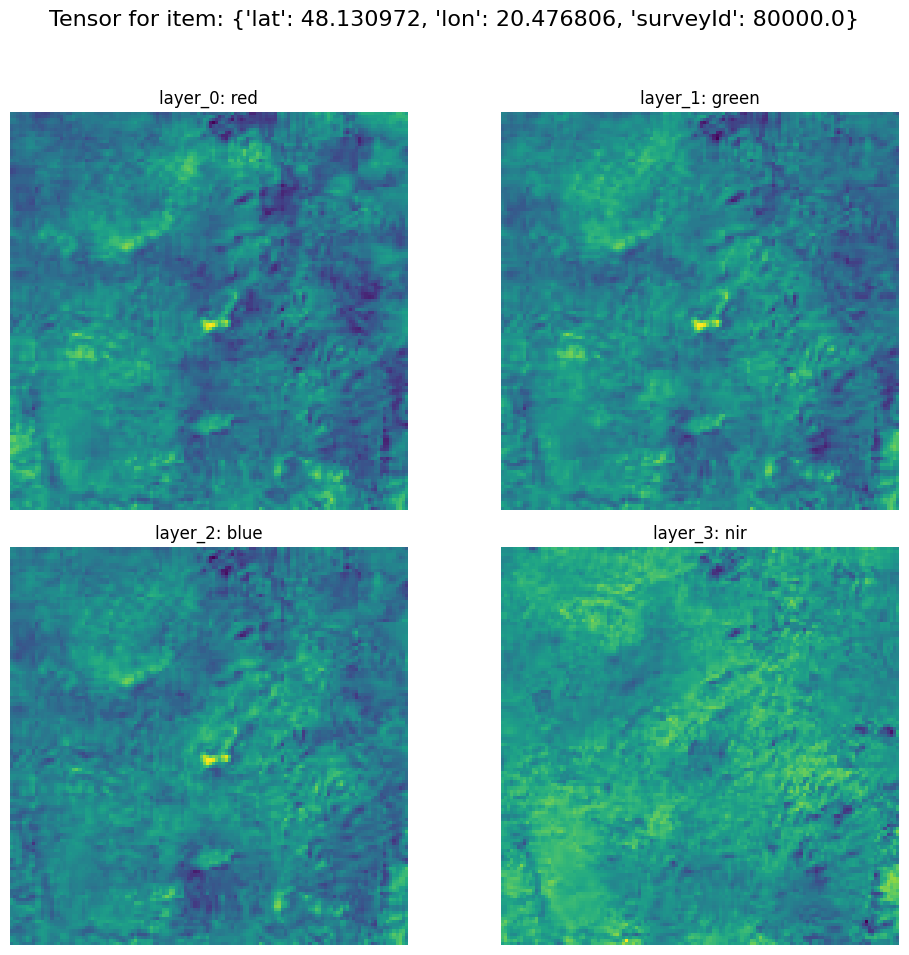

In [14]:
sat_provider = JpegPatchProvider(
    'dataset/scale_3_satellite/data_subset/PA_Train_SatellitePatches/',
    select=['red','green','blue','nir'],
    size=128, # default value, that of he pre-extracted patches
)
sat_dataset = PatchesDataset(occurrences='dataset/scale_3_satellite/data_subset/GLC24-PA-data_subset.csv',
                             providers=[sat_provider],
                             item_columns=['lat', 'lon', 'surveyId'],
                             labels_name=['lat', 'lon'],
)


# img_sat = sat_provider[{'surveyId': 80000}]
img_sat, (sat_lat, sat_lon) = sat_dataset[0]
sat_dataset.plot_patch(0)

### Landscape

Image 2006/FR/352/627/35262736C.jpg not found.
Image 2006/FR/352/627/35262736S.jpg not found.
Image 2006/FR/352/627/35262736N.jpg not found.
Image 2006/FR/352/627/35262736W.jpg not found.
Image 2006/FR/352/627/35262736E.jpg not found.


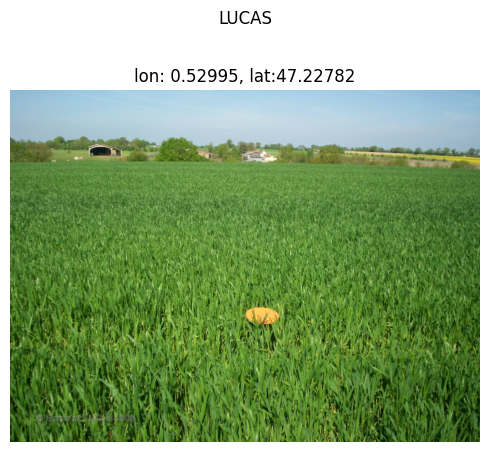

In [15]:
def load_LUCAS_img(
    id: Union[str, int],
    metadata: pd.DataFrame,
    root_path: str = "dataset/scale_2_landscape/",
    views: list = ['cover', 'south', 'north', 'west', 'east', 'point'],  # Takes values in [cover, south, north, west, east, point]
    return_img_path: Optional[bool] = False,
    return_img_gps: Optional[bool] = False,
    id_col: str = 'id',
):
    img, fps = [], []
    metadata = metadata[metadata[id_col] == id].copy()
    gps = tuple(metadata[['gps_long', 'gps_lat']].values.flatten())
    if not 'file_path_gisco_cover' in metadata.columns:
        metadata['file_path_gisco_cover'] = metadata['file_path_gisco_north'].copy()
        metadata['file_path_gisco_cover'] = metadata['file_path_gisco_cover'].apply(lambda x: str(Path(x).parent / Path(Path(x).stem[:-1] + 'C' + Path(x).suffix)))
    for v in views:
        try:
            fp = '/'.join(metadata[f'file_path_gisco_{v}'].values[0].split('/')[-5:])
            img.append(torchvision.io.read_image(str(Path(root_path) / Path(fp))))
            fps.append(fp)
        except:
            print(f"Image {fp} not found.")
    img = torch.stack(img, dim=0)
    if return_img_gps and return_img_path:
        return img, gps, fps
    if return_img_gps:
        return img, gps
    if return_img_path:
        return img, fps
    return img

root_path = "dataset/scale_2_landscape/LUCAS_subset"
metadata = pd.read_csv(Path(root_path) / Path("metadata_subset.csv"))
img_lucas, (lon, lat), fps_lucas = load_LUCAS_img(565755,
                                                 metadata.copy(),
                                                 root_path=root_path,
                                                 return_img_path=True,
                                                 return_img_gps=True)
title = [f'lon: {lon}, lat:{lat}']
plot_img(img_lucas, title, suptitle='LUCAS')

### Species

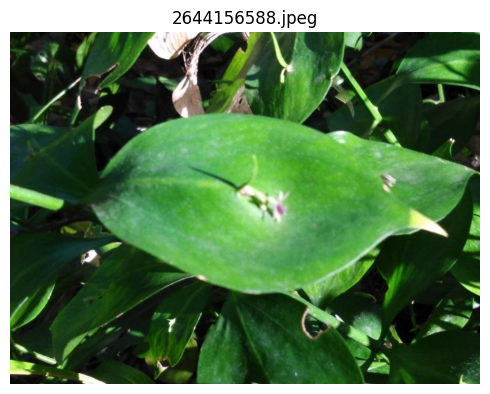

In [16]:
def load_species_img(
    id: Union[str, int],
    img_dir: Optional[str] = 'dataset/images/scale_1_species/',
    img_formats: Optional[List[str]] = ['jpeg', 'jpg', 'png'],
    return_img_path: Optional[bool] = False,
):
    for img_format in img_formats:
        img_path = Path(os.path.join(img_dir, f"{id}.{img_format}"))
        if os.path.exists(img_path):
            img = torchvision.io.read_image(str(img_path))
            if return_img_path:
                return img.unsqueeze(0), [img_path.name]
            return img.unsqueeze(0)
    raise FileNotFoundError(f"No matching image found for id: {id}")


img_species, fp_species = load_species_img('2644156588', 'dataset/scale_1_species/data_subset/img/', return_img_path=True)
plot_img(img_species, fp_species)

In [17]:
class DatasetSimple(Dataset):
    def __init__(
        self,
        root_path: str = None,
        fp_metadata: str = None,
        transform: Callable = None,
        dataset_kwargs: dict = {},
        **kwargs,
    ) -> None:
        super().__init__()
        self.root_path = root_path
        self.metadata = pd.read_csv(f'{Path(fp_metadata)}') if fp_metadata is not None else pd.DataFrame()
        self.transform = lambda x: x if transform is None else transform
        self.dataset_kwargs = dataset_kwargs
        self.img, self.coords = torch.empty(0), (-np.inf, -np.inf)
        
    def __len__(self):
        return len(self.metadata)
    
    @abstractmethod
    def __getitem__(self, index) -> Any:
        """Returns a sample of the dataset."""


class SpeciesDatasetSimple(DatasetSimple):
    def __init__(
        self,
        root_path: str = None,
        fp_metadata: str = None,
        transform: Callable = None,
        dataset_kwargs: dict = {},
        **kwargs,
    ) -> None:
        super().__init__(root_path, fp_metadata, transform, dataset_kwargs, **kwargs)

    def __getitem__(self, index) -> Any:
        img, coords = self.img, self.coords
        if not self.metadata.empty:
            sample = self.metadata.iloc[index]
            img = load_species_img(sample['gbifID'], self.root_path, **self.dataset_kwargs)
            img = img.to(torch.float32)
            img = self.transform(img)
            coords = tuple(sample[['decimalLongitude', 'decimalLatitude']].values.flatten())
        
        return {'img': img, 'gps': coords}


class LandscapeDatasetSimple(DatasetSimple):
    def __init__(
        self,
        root_path: str = None,
        fp_metadata: str = None,
        transform: Callable = None,
        dataset_kwargs: dict = {},
        **kwargs,
    ) -> None:
        super().__init__(root_path, fp_metadata, transform, dataset_kwargs, **kwargs)
    
    def __getitem__(self, index) -> Any:
        img, coords = self.img, self.coords
        if not self.metadata.empty:
            sample = self.metadata.iloc[index]
            img = load_LUCAS_img(sample['id'], self.metadata, self.root_path, **self.dataset_kwargs)
            img = img.to(torch.float32)
            img = self.transform(img)
            coords = tuple(sample[['gps_long', 'gps_lat']].values.flatten())

        return {'img': img, 'gps': coords}


class SatelliteDatasetSimple(DatasetSimple):
    def __init__(
        self,
        root_path: str = None,
        fp_metadata: str = None,
        transform: Callable = None,
        kwargs_sat_provider: dict = {'select': ['red','green','blue','nir'],
                                     'size': 128},
        kwargs_sat_dataset: dict = {'item_columns': ['lat', 'lon', 'surveyId'],
                                    'labels_name': ['lat', 'lon']},
        **kwargs,
    ) -> None:
        super().__init__(root_path, fp_metadata, transform, **kwargs)
        if not self.metadata.empty:
            self.sat_provider = JpegPatchProvider(
                self.root_path,  # 'dataset/scale_3_satellite/data_subset/PA_Train_SatellitePatches/',
                **kwargs_sat_provider, # default value, that of he pre-extracted patches
            )
            self.sat_dataset = PatchesDataset(
                occurrences=fp_metadata,  # 'dataset/scale_3_satellite/GLC24-PA-data_subset.csv',
                providers=[self.sat_provider],
                **kwargs_sat_dataset,
            )

    def __getitem__(self, index) -> Any:
        img, coords = self.img, self.coords
        if not self.metadata.empty:
            img, (sat_lat, sat_lon) = self.sat_dataset[index]  # Same as: sat_provider[{'surveyId': 80000}]
            img = torch.unsqueeze(img, dim=0)  # Adds a batch dimension
            img = img.to(torch.float32)
            img = self.transform(img)
            coords = (sat_lon, sat_lat)

        return {'img': img, 'gps': coords}

In [18]:
dataset_species = SpeciesDatasetSimple(
    root_path = 'dataset/scale_1_species/data_subset/img',
    fp_metadata = 'dataset/scale_1_species/data_subset/metadata_subset.csv',
    transform = None,
)
species_data_sample = dataset_species[0]
print(len(species_data_sample), species_data_sample['img'].shape, species_data_sample['gps'])

dataset_landscape = LandscapeDatasetSimple(
    root_path = 'dataset/scale_2_landscape/LUCAS_subset',
    fp_metadata = 'dataset/scale_2_landscape/LUCAS_subset/metadata_subset.csv',
    transform = None,
)
landscape_data_sample = dataset_landscape[0]
print(len(landscape_data_sample), landscape_data_sample['img'].shape, landscape_data_sample['gps'])

dataset_satellite = SatelliteDatasetSimple(
    root_path = 'dataset/scale_3_satellite/data_subset/PA_Train_SatellitePatches/',
    fp_metadata = 'dataset/scale_3_satellite/data_subset/GLC24-PA-data_subset.csv',
    transform = None,
)
satellite_data_sample = dataset_satellite[0]
print(len(satellite_data_sample), satellite_data_sample['img'].shape, satellite_data_sample['gps'])

2 torch.Size([1, 3, 900, 450]) (np.float64(4.207229083333334), np.float64(43.8686665))
Image 2006/FR/352/627/35262736C.jpg not found.
Image 2006/FR/352/627/35262736S.jpg not found.
Image 2006/FR/352/627/35262736N.jpg not found.
Image 2006/FR/352/627/35262736W.jpg not found.
Image 2006/FR/352/627/35262736E.jpg not found.
2 torch.Size([1, 3, 1248, 1664]) (np.float64(0.52995), np.float64(47.22782))
2 torch.Size([1, 4, 128, 128]) (np.float64(20.476806), np.float64(48.130972))


In [19]:
class MultiscaleDatasetSimple(Dataset):
    def __init__(
        self,
        root_path_species: str = None,
        fp_metadata_species: str = None,
        root_path_landscape: str = None,
        fp_metadata_landscape: str = None,
        root_path_satellite: str = None,
        fp_metadata_satellite: str = None,
        transform_species: Callable = None,
        transform_landscape: Callable = None,
        transform_satellite: Callable = None,
        kwargs_sat_provider: dict = {'select': ['red','green','blue','nir'],
                                     'size': 128},
        kwargs_sat_dataset: dict = {'item_columns': ['lat', 'lon', 'surveyId'],
                                    'labels_name': ['lat', 'lon']},
        **kwargs,
    ) -> None:
        super().__init__()
        self.root_path_species = root_path_species
        self.root_path_landscape = root_path_landscape
        self.root_path_satellite = root_path_satellite
        self.metadata_species = pd.read_csv(f'{Path(fp_metadata_species)}') if fp_metadata_species is not None else pd.DataFrame()
        self.metadata_landscape = pd.read_csv(f'{Path(fp_metadata_landscape)}') if fp_metadata_landscape is not None else pd.DataFrame()
        self.metadata_satellite = pd.read_csv(f'{Path(fp_metadata_satellite)}') if fp_metadata_satellite is not None else pd.DataFrame()
        self.transforms = {'species': lambda x: x if transform_species is None else transform_species,
                           'landscape': lambda x: x if transform_landscape is None else transform_landscape,
                           'satellite': lambda x: x if transform_satellite is None else transform_satellite}
        
        self.sat_provider = JpegPatchProvider(
            self.root_path_satellite,  # 'dataset/scale_3_satellite/data_subset/PA_Train_SatellitePatches/',
            **kwargs_sat_provider, # default value, that of he pre-extracted patches
        )
        self.sat_dataset = PatchesDataset(
            occurrences=fp_metadata_satellite,  # 'dataset/scale_3_satellite/GLC24-PA-data_subset.csv',
            providers=[self.sat_provider],
            **kwargs_sat_dataset,
        )
        
    def __len__(self):
        return max(len(self.metadata_species), len(self.metadata_landscape), len(self.metadata_satellite))
    
    def __getitem__(self, index) -> Any:
        # Species
        species_img, species_coords = None, None
        if not self.metadata_species.empty:
            species_sample = self.metadata_species.iloc[index]
            species_img = load_species_img(species_sample['gbifID'], self.root_path_species)
            species_img = self.transforms['species'](species_img)
            species_coords = tuple(species_sample[['decimalLongitude', 'decimalLatitude']].values.flatten())
        
        # Landscape
        landscape_img, landscape_coords = None, None
        if not self.metadata_landscape.empty:
            landscape_sample = self.metadata_landscape.iloc[index]
            landscape_img = load_LUCAS_img(landscape_sample['id'], self.metadata_landscape, self.root_path_landscape)
            landscape_img = self.transforms['landscape'](landscape_img)
            landscape_coords = tuple(landscape_sample[['gps_long', 'gps_lat']].values.flatten())
        
        # Satellite
        satellite_img, satellite_coords = None, None
        if not self.metadata_satellite.empty:
            satellite_img, (sat_lat, sat_lon) = self.sat_dataset[index]  # Same as: sat_provider[{'surveyId': 80000}]
            satellite_img = torch.unsqueeze(satellite_img, dim=0)  # Adds a batch dimension
            satellite_img = self.transforms['satellite'](satellite_img)
            satellite_coords = (sat_lon, sat_lat)

        sample = {'species':
                    {'img': species_img,
                     'gps': species_coords},
                  'landscape':
                    {'img': landscape_img,
                     'gps': landscape_coords},
                  'satellite':
                    {'img': satellite_img,
                     'gps': satellite_coords}}
        return sample

In [20]:
dataset = MultiscaleDatasetSimple(
    root_path_species = 'dataset/scale_1_species/data_subset/img',
    fp_metadata_species = None, # 'dataset/scale_1_species/data_subset/metadata_subset.csv',
    root_path_landscape = 'dataset/scale_2_landscape/LUCAS_subset',
    fp_metadata_landscape = None,  # 'dataset/scale_2_landscape/LUCAS_subset/metadata_subset.csv',
    root_path_satellite = 'dataset/scale_3_satellite/data_subset/PA_Train_SatellitePatches/',
    fp_metadata_satellite = 'dataset/scale_3_satellite/data_subset/GLC24-PA-data_subset.csv',
    transform_species = None,
    transform_landscape = None,
    transform_satellite = None,
)

data_sample = dataset[0]

print(f'Data sample length: {len(dataset)}')
display(data_sample)

Data sample length: 334


{'species': {'img': None, 'gps': None},
 'landscape': {'img': None, 'gps': None},
 'satellite': {'img': tensor([[[[ 71.,  70.,  68.,  ...,  86.,  84.,  80.],
            [ 70.,  69.,  67.,  ...,  85.,  85.,  84.],
            [ 72.,  72.,  69.,  ...,  82.,  83.,  85.],
            ...,
            [ 81.,  79.,  77.,  ...,  88.,  83.,  73.],
            [ 82.,  80.,  78.,  ...,  88.,  82.,  76.],
            [ 76.,  80.,  81.,  ...,  89.,  83.,  79.]],
  
           [[ 79.,  78.,  76.,  ...,  78.,  74.,  70.],
            [ 78.,  77.,  75.,  ...,  77.,  77.,  76.],
            [ 78.,  78.,  75.,  ...,  76.,  77.,  79.],
            ...,
            [ 85.,  83.,  80.,  ...,  94.,  90.,  80.],
            [ 86.,  84.,  81.,  ...,  94.,  89.,  83.],
            [ 80.,  84.,  84.,  ...,  95.,  90.,  86.]],
  
           [[ 66.,  65.,  63.,  ...,  65.,  62.,  58.],
            [ 65.,  64.,  62.,  ...,  64.,  64.,  63.],
            [ 66.,  66.,  63.,  ...,  62.,  63.,  65.],
            ...,

### Models

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/tlarcher/virtual_envs/jrc/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#### Species

In [14]:
model_root_path_species = 'weights/scale_1_species/'
class_mapping = str(Path(model_root_path_species) / Path('class_mapping.txt'))
species_mapping = str(Path(model_root_path_species) / Path('species_id_to_name.txt'))
pretrained_path = str(Path(model_root_path_species) / Path('vit_base_patch14_reg4_dinov2_lvd142m_pc24_onlyclassifier_then_all_best.pth.tar'))

def load_class_mapping(class_list_file):
    with open(class_list_file) as f:
        class_index_to_class_name = {i: line.strip() for i, line in enumerate(f)}
    return class_index_to_class_name


def load_species_mapping(species_map_file):
    df = pd.read_csv(species_map_file, sep=";", quoting=1, dtype={"species_id": str})
    df = df.set_index("species_id")
    return df["species"].to_dict()

In [15]:
cid_to_spid = load_class_mapping(class_mapping)
spid_to_sp = load_species_mapping(species_mapping)

device = torch.device(device)

model_species = timm.create_model(
    'vit_base_patch14_reg4_dinov2.lvd142m',
    pretrained=False,
    num_classes=len(cid_to_spid),
    checkpoint_path=pretrained_path,
)

- **Check model conformity**

cf. https://huggingface.co/timm/vit_base_patch14_reg4_dinov2.lvd142m

In [39]:
model_species.eval()
model_species.to(device)
img = species_data_sample['img'].to(device)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_species)
transforms_species = timm.data.create_transform(**data_config, is_training=False)

# output is unpooled, a (1, 1374, 768) shaped tensor
features_species = model_species.forward_features(transforms_species(img))

In [42]:
print(img.shape)
print(900*450)


torch.Size([1, 3, 900, 450])
405000


In [40]:
features_species.shape

torch.Size([1, 1374, 768])

In [29]:
model_species

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [53]:
from transformers import ViTConfig, ViTModel

configuration = ViTConfig()
model = ViTModel(configuration)
configuration = model.config
print(configuration)

ViTConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.50.3"
}



In [66]:
from copy import deepcopy

model2 = deepcopy(model_species)
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model2.patch_embed.register_forward_hook(get_activation('pointer'))
features2 = model2(transforms_species(img))
print(activation['pointer'].shape)

torch.Size([1, 1369, 768])


#### Landscape

In [26]:
model_root_path_landscape = 'weights/scale_2_landscape/'

In [27]:
model_landscape = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=1,
)

#### Satellite

In [36]:
from omegaconf import DictConfig, OmegaConf
from malpolon.models.utils import check_loss, check_model, check_optimizer, check_scheduler

model_root_path_satellite = 'weights/scale_3_satellite/'
model_satellite_config = str(Path(model_root_path_satellite) / Path('glc24_cnn_multimodal_ensemble.yaml'))
ckpt_path = str(Path(model_root_path_satellite) / 'pretrained.ckpt')

def remove_state_dict_prefix(
    state_dict: dict,
    sep: str = '.',
    n_prefix: int = 1,
):
    """Remove a prefix from the keys of a state_dict."""
    for key in list(state_dict):
        state_dict['.'.join(key.split(sep)[n_prefix:])] = state_dict.pop(key)
    print(f'State_dict: removed {n_prefix} prefix based on separator "{sep}" from {len(state_dict)} keys')
    return state_dict

In [53]:
model_config = OmegaConf.load(model_satellite_config)
model = check_model(model_config.model)
checkpoint = torch.load(ckpt_path)
state_dict = remove_state_dict_prefix(checkpoint['state_dict'].copy())
if 'pos_weight' in state_dict:
    pos_weight = state_dict.pop('pos_weight')
model.load_state_dict(state_dict)
model_satellite = model.sentinel_model

State_dict: removed 1 prefix based on separator "." from 440 keys


#### Contrastive training pairwise

In [55]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Hyperparameters
learning_rate = 0.00025
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=25)

In [ ]:
print(f"Training for {num_epochs} epochs started.")
pairs = [(model_species, dataset_species), (model_landscape, dataset_landscape), (model_satellite, dataset_satellite)]

# for epoch in range(num_epochs):
#     model.train()
    
#     for batch_idx, (data1, data2, data3, targets, _) in enumerate(train_loader):

#         data1 = data1.to(device)
#         data2 = data2.to(device)
#         data3 = data3.to(device)
#         targets = targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(data1, data2, data3)

#         pos_weight = targets*positive_weigh_factor  # All positive weights are equal to 10
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#         loss = criterion(outputs, targets)

#         loss.backward()
#         optimizer.step()

#         if batch_idx % 278 == 0:
#             print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

#     scheduler.step()
#     print("Scheduler:",scheduler.state_dict())

# # Save the trained model
# model.eval()
# torch.save(model.state_dict(), "multimodal-model.pth")

## Area of Interest intersection (step 2)

We have a mask raster over the CBN-med area that we can use to create a unique indexing for the geodataframes.

In [2]:
def make_unique_id(
    row: int,
    col: int,
    max_row: int = 488,
    max_col: int = 1081,
) -> int:
    """Generate a unique identifier from (row, col) coordinates.
    
    Args:
        row (int): Row index (0 to 488).
        col (int): Column index (0 to 1081).
        max_col (int): Maximum column index (default 1081).
    
    Returns:
        int: Unique identifier.
    """
    if not (0 <= row <= max_row) or not (0 <= col <= max_col):
        raise ValueError("Row must be in [0, 488] and Col in [0, 1081].")
    
    return row * (max_col + 1) + col

In [3]:
src = rasterio.open('dataset/CBN-med_raster_epsg4326.tif')
crs = src.crs
meta = src.meta
xmin, ymin, xmax, ymax = src.bounds
transform = src.transform
raster = src.read(1)
print(f'Raster shape: {raster.shape}. Size: {raster.size}')
print(meta)

Raster shape: (489, 1082). Size: 529098
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 1082, 'height': 489, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.005903245798812977, 0.0, 1.3832495894095402,
       0.0, -0.005903245798812977, 45.15923623745561)}


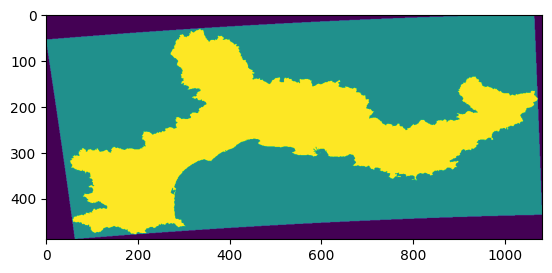

In [14]:
plt.imshow(raster)
plt.show()

In [24]:
inds = np.argwhere(raster == 1)
uids = []
print(inds)
for i in inds:
    uids.append(make_unique_id(i[0], i[1], max_row=raster.shape[0], max_col=raster.shape[1]))
uids = np.array(uids)
print(len(np.unique(uids)), raster.size, 'equal ? :', len(np.unique(uids)) == raster.size)

[[ 31 336]
 [ 32 335]
 [ 32 336]
 ...
 [478 194]
 [478 195]
 [478 196]]
149574 529098 equal ? : False


In [6]:
# Example row, col indices
row, col = 31, 336

# Convert to longitude, latitude
lon, lat = rasterio.transform.xy(transform, row, col)

print(f"Pixel ({row}, {col}) -> Lon: {lon}, Lat: {lat}")

Pixel (31, 336) -> Lon: 3.369691800710107, Lat: 44.973283994793
